# Weekly Project: Image Classification with Transfer Learning

In this project, you will build a complete image classification pipeline using transfer learning. You'll work with the dataset provided by your instructor.

**Learning Objectives:**
- Load and prepare image datasets for deep learning
- Use pre-trained models for transfer learning
- Implement two transfer learning strategies: fine-tuning and feature extraction
- Evaluate model performance
- Deploy models using ONNX for production (Optional)

**References:**

- [Training with PyTorch](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Table of Contents

1. [Data Ingestion](#1)
2. [Data Preparation](#2)
3. [Model Building](#3)
4. [Training](#4)
   - [4.1 ConvNet as Fixed Feature Extractor](#4-1)
   - [4.2 Fine-tuning the ConvNet](#4-2)
5. [Evaluation](#5)
6. [Inference on Custom Images](#6)
7. [Deployment (ONNX)](#7)

## Imports

In [ ]:
import os
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import kagglehub
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision
import helper_utils

## Setup Device

**Note: you will need a GPU; so please run this on Colab and specify a GPU runtime (e.g., T4-GPU)**

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<a name='1'></a>
## 1. Data Ingestion

**Task**: The dataset should be downloaded and extracted to a local directory.

**References:**

- [Dataset and DataLoader](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader)
- [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

In [ ]:
# downloads & caches automatically
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
data_root = Path(path)
print("Dataset path:", data_root)
print(list(data_root.iterdir())[:10])


Using Colab cache for faster access to the 'intel-image-classification' dataset.
Dataset path: /kaggle/input/intel-image-classification
[PosixPath('/kaggle/input/intel-image-classification/seg_train'), PosixPath('/kaggle/input/intel-image-classification/seg_pred'), PosixPath('/kaggle/input/intel-image-classification/seg_test')]


**Task**: create a `train_dataset` and `test_dataset` (without transforms for now).

In [ ]:
# Download dataset and get local path
data_path = Path(
    kagglehub.dataset_download("puneet6060/intel-image-classification")
)

# Intel Image Classification folder structure
train_path = data_path / "seg_train" / "seg_train"
test_path  = data_path / "seg_test" / "seg_test"

# Create datasets (no transforms)
train_dataset = datasets.ImageFolder(root=train_path)
test_dataset  = datasets.ImageFolder(root=test_path)

Using Colab cache for faster access to the 'intel-image-classification' dataset.


**Quick Check**: verify the counts of both train and test sets, match what's in the original source (Kaggle).

In [ ]:
# Sanity check
print(len(train_dataset), len(test_dataset))
print(train_dataset.classes)

14034 3000
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


<a name='2'></a>
## 2. Data Preparation

Before training, we need to:
1. Define augmentation for training
2. Define normalization for both training and testing
3. Create **`DataLoader`** for efficient batch processing

**Task:** Create transformation pipelines for training and validation. Pre-trained models expect ImageNet normalization statistics.

**Reference:**

- [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)

In [ ]:
# ImageNet stats (required for pretrained models)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [ ]:
# Attach transforms to datasets
train_dataset.transform = train_transforms
test_dataset.transform  = val_transforms

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)
dataloaders = {
    'train': train_loader,
    'val': test_loader
}

# Sanity check
images, labels = next(iter(train_loader))
print(images.shape)   # (batch_size, 3, 224, 224)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


**Quick Check**: Visualize a batch of training images

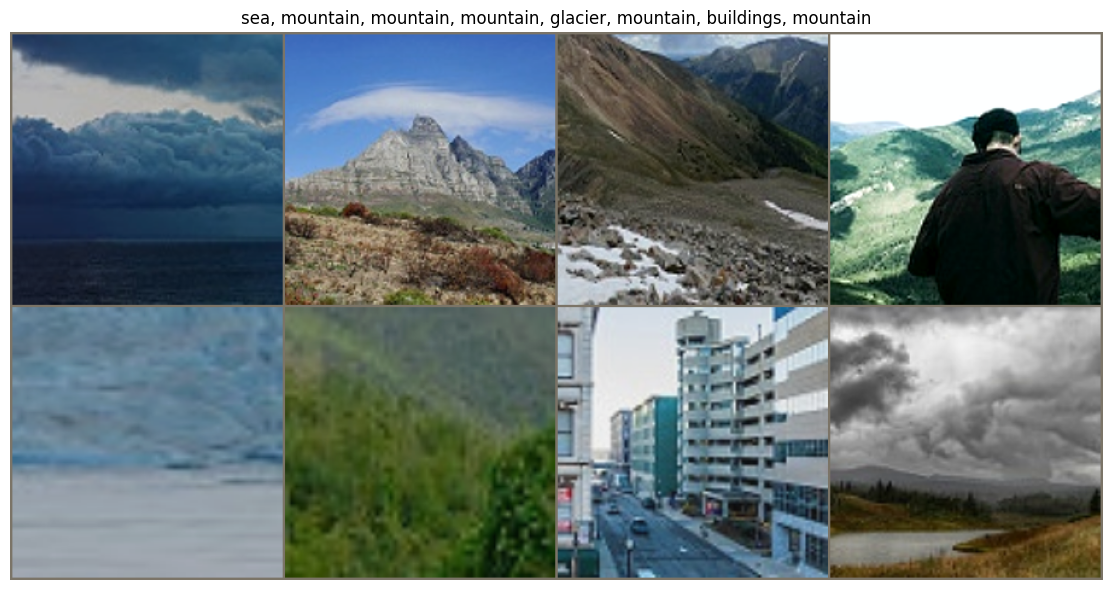

In [ ]:
class_names = train_dataset.classes
helper_utils.visualize_batch(train_loader, class_names)
plt.show()

<a name='3'></a>
## 3. Model Building

We'll use a pre-trained ResNet-18 model and adapt it for our 6-class classification task.

**Task:** Load a pre-trained ResNet-18 model and modify the final layer for 6 classes.

**Reference:**

- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [torchvision.models](https://pytorch.org/vision/stable/models.html)
- [ResNet documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)

In [ ]:
# Load pretrained ResNet-18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Replace final layer for 6 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)

# Move to device
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 240MB/s]


<a name='4'></a>
## 4. Training

**Task:** Implement a training **function** and then train using two different transfer learning strategies.

**Reference:** [PyTorch Training Tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)

In [44]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, run_name="default"):
    since = time.time()

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # create directory for checkpoints
    ckpt_dir = Path("checkpoints")
    ckpt_dir.mkdir(parents=True, exist_ok=True)

    # save best params here
    best_model_params_path = ckpt_dir / f"best_model_params_{run_name}.pt"

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                loader = train_loader
                ds_size = len(train_loader.dataset)
            else:
                model.eval()
                loader = test_loader
                ds_size = len(test_loader.dataset)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / ds_size
            epoch_acc = running_corrects.double() / ds_size

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # collect history
            if phase == "train":
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            # save best parameters to file
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")
    print(f"Best params saved to: {best_model_params_path}")

    model.load_state_dict(best_model_wts)

    history_conv = {
    "train_loss": train_loss_history,
    "val_loss": val_loss_history,
    "train_acc": train_acc_history,
    "val_acc": val_acc_history,
}


    return model, history_conv


<a name='4-1'></a>
### 4.1 ConvNet as Fixed Feature Extractor

In this approach, we freeze all the convolutional layers and only train the final classifier layer.

**Task:**

1. Load a fresh pre-trained model
2. Freeze all parameters except the final layer
3. Set up optimizer to only train the final layer
4. Train the model

In [45]:
# Load a fresh pre-trained ResNet-18
model_fe = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [46]:
# Freeze all parameters
for param in model_fe.parameters():
    param.requires_grad = False

# Replace final layer (6 classes)
num_ftrs = model_fe.fc.in_features
model_fe.fc = nn.Linear(num_ftrs, 6)

# Move model to device
model_fe = model_fe.to(device)


In [47]:
# Optimizer: only train final layer
criterion = nn.CrossEntropyLoss()
optimizer_fe = optim.SGD(model_fe.fc.parameters(), lr=0.001, momentum=0.9)
scheduler_fe = optim.lr_scheduler.StepLR(optimizer_fe, step_size=7, gamma=0.1)

In [48]:
# Train the model
model_fe , history_fe = train_model(
    model_fe,
    criterion,
    optimizer_fe,
    scheduler_fe,
    num_epochs=10,
    run_name="feature_extraction"
)

Epoch 0/9
----------
train Loss: 0.6505 Acc: 0.7686
val Loss: 0.3297 Acc: 0.8843

Epoch 1/9
----------
train Loss: 0.4568 Acc: 0.8306
val Loss: 0.2873 Acc: 0.8977

Epoch 2/9
----------
train Loss: 0.4220 Acc: 0.8475
val Loss: 0.2724 Acc: 0.9060

Epoch 3/9
----------
train Loss: 0.4301 Acc: 0.8403
val Loss: 0.2660 Acc: 0.9093

Epoch 4/9
----------
train Loss: 0.3984 Acc: 0.8558
val Loss: 0.2644 Acc: 0.9087

Epoch 5/9
----------
train Loss: 0.4043 Acc: 0.8517
val Loss: 0.2670 Acc: 0.9037

Epoch 6/9
----------
train Loss: 0.4078 Acc: 0.8516
val Loss: 0.2544 Acc: 0.9103

Epoch 7/9
----------
train Loss: 0.3853 Acc: 0.8583
val Loss: 0.2574 Acc: 0.9127

Epoch 8/9
----------
train Loss: 0.3918 Acc: 0.8586
val Loss: 0.2580 Acc: 0.9093

Epoch 9/9
----------
train Loss: 0.3929 Acc: 0.8561
val Loss: 0.2582 Acc: 0.9120

Training complete in 6m 39s
Best val Acc: 0.9127
Best params saved to: checkpoints/best_model_params_feature_extraction.pt


**Quick Check**: Visualize training history

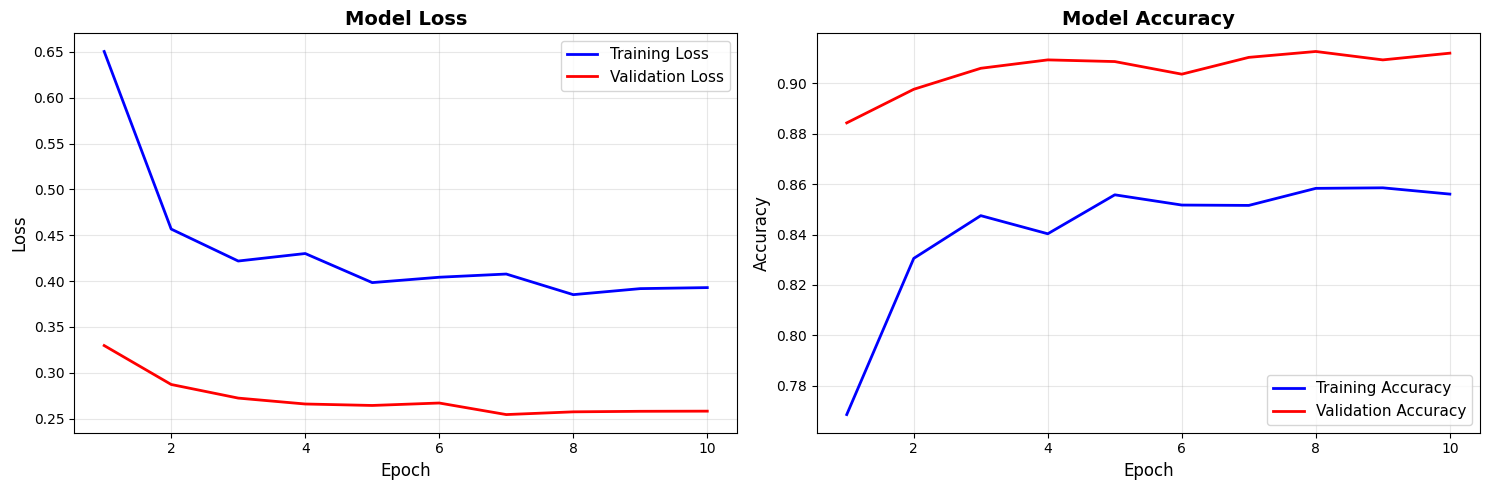

In [49]:
helper_utils.visualize_training_history(history_fe)
plt.show()

**Quick Check**: Visualize predictions

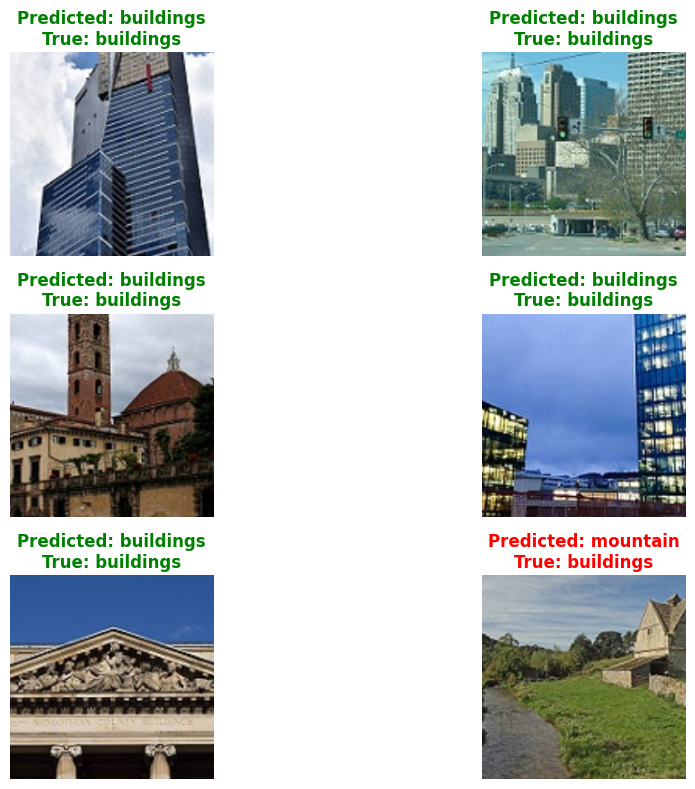

In [50]:
helper_utils.visualize_predictions(model_fe, dataloaders['val'], class_names, device, num_images=6)
plt.show()

<a name='4-2'></a>
### 4.2 Fine-tuning the ConvNet

In this approach, we unfreeze all layers and train the entire network with a smaller learning rate.

**Task:**

1. Load a fresh pre-trained model
2. Modify the final layer
3. Set up optimizer for all parameters with a smaller learning rate
4. Train the model

In [51]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [52]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 6)
model_ft = model_ft.to(device)

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
scheduler_ft = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [54]:
model_ft, history_ft = train_model(
    model_ft,
    criterion,
    optimizer_ft,
    scheduler_ft,
    num_epochs=10,
    run_name="fine_tuning")

Epoch 0/9
----------
train Loss: 0.4897 Acc: 0.8251
val Loss: 0.2138 Acc: 0.9243

Epoch 1/9
----------
train Loss: 0.3409 Acc: 0.8747
val Loss: 0.2155 Acc: 0.9220

Epoch 2/9
----------
train Loss: 0.3110 Acc: 0.8832
val Loss: 0.1903 Acc: 0.9323

Epoch 3/9
----------
train Loss: 0.2910 Acc: 0.8929
val Loss: 0.1853 Acc: 0.9340

Epoch 4/9
----------
train Loss: 0.2745 Acc: 0.9007
val Loss: 0.1872 Acc: 0.9350

Epoch 5/9
----------
train Loss: 0.2651 Acc: 0.9007
val Loss: 0.2045 Acc: 0.9287

Epoch 6/9
----------
train Loss: 0.2558 Acc: 0.9046
val Loss: 0.1884 Acc: 0.9337

Epoch 7/9
----------
train Loss: 0.2324 Acc: 0.9151
val Loss: 0.1760 Acc: 0.9370

Epoch 8/9
----------
train Loss: 0.2186 Acc: 0.9201
val Loss: 0.1746 Acc: 0.9393

Epoch 9/9
----------
train Loss: 0.2120 Acc: 0.9225
val Loss: 0.1742 Acc: 0.9410

Training complete in 6m 33s
Best val Acc: 0.9410
Best params saved to: checkpoints/best_model_params_fine_tuning.pt


**Quick Check**: Visualize training history

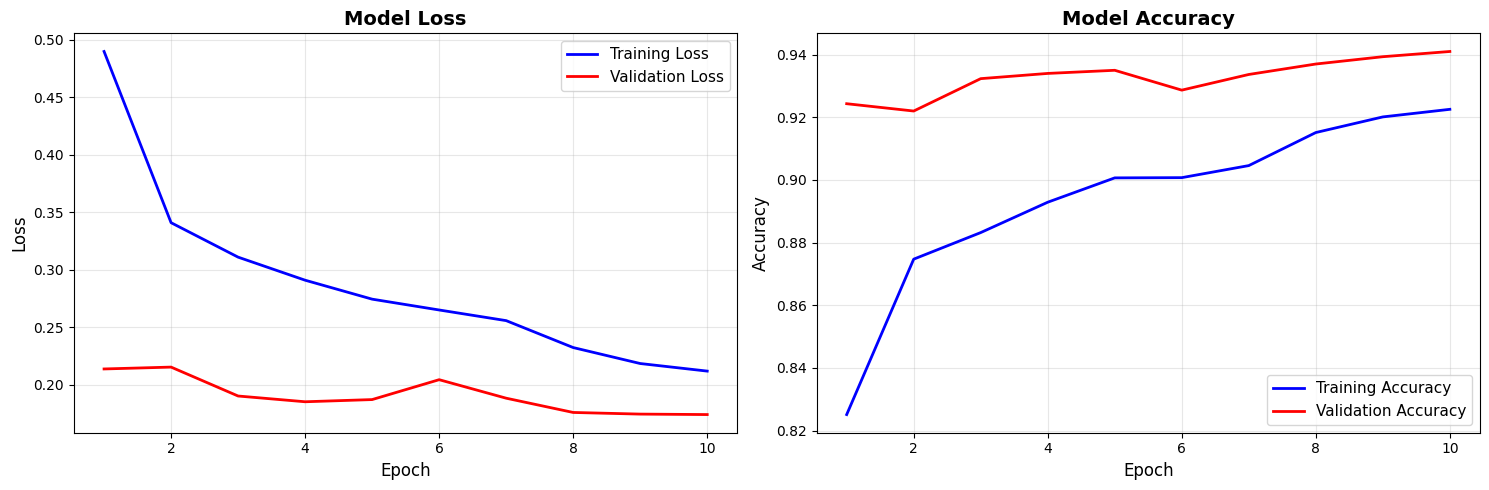

In [55]:
helper_utils.visualize_training_history(history_ft)
plt.show()

**Quick Check**: Visualize predictions

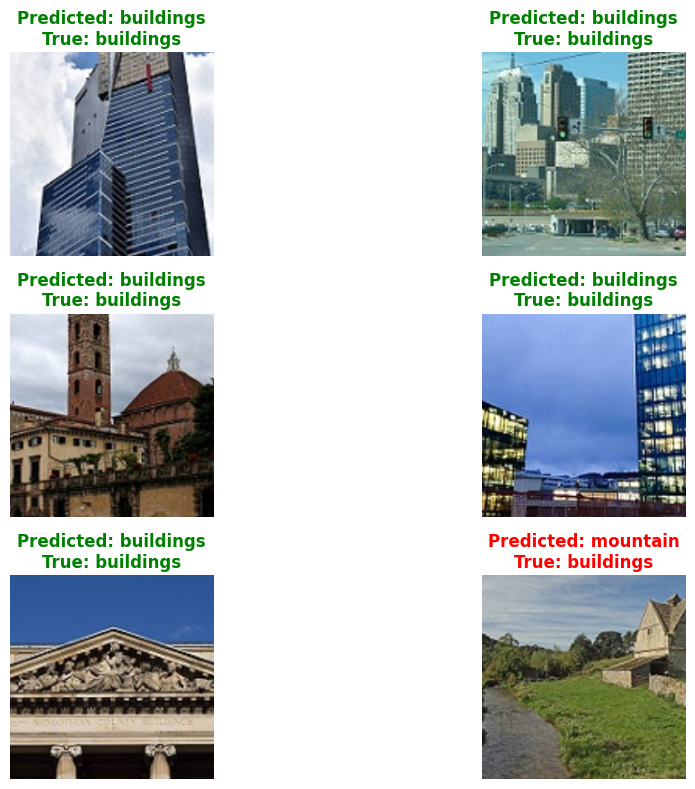

In [56]:
helper_utils.visualize_predictions(model_ft, dataloaders['val'], class_names, device, num_images=6)
plt.show()

In [58]:
# save full models
torch.save(model_fe, "checkpoints/model_fe_full.pt")
torch.save(model_ft, "checkpoints/model_ft_full.pt")

<a name='5'></a>
## 5. Evaluation

Compare the performance of both approaches.

**Task:** Evaluate both models and compare their performance metrics.

In [57]:
# Evaluate models on validation set
print("Feature Extractor Approach:")
print(f"  Best Val Accuracy: {max(history_fe['val_acc']):.4f}")
print(f"  Final Val Accuracy: {history_fe['val_acc'][-1]:.4f}")
print()
print("Fine-tuning Approach:")
print(f"  Best Val Accuracy: {max(history_ft['val_acc']):.4f}")
print(f"  Final Val Accuracy: {history_ft['val_acc'][-1]:.4f}")

Feature Extractor Approach:
  Best Val Accuracy: 0.9127
  Final Val Accuracy: 0.9120

Fine-tuning Approach:
  Best Val Accuracy: 0.9410
  Final Val Accuracy: 0.9410


<a name='6'></a>
## 6. Inference on Custom Images

Test your trained model on custom images.

**Task:** Load a custom image, preprocess it, and make a prediction using your trained model.

**Reference:** [Image Preprocessing](https://pytorch.org/vision/stable/transforms.html)

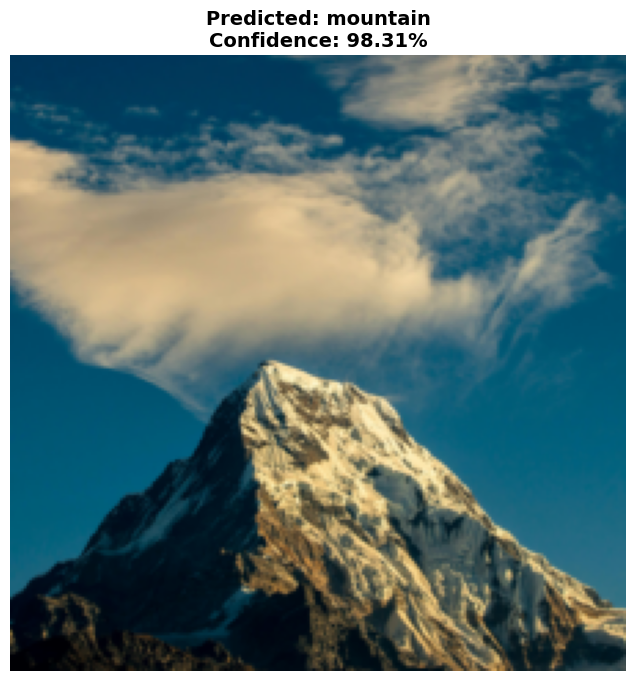

In [60]:
img_path = "inf_img/pexels-pixabay-326235.jpg"

# model in eval mode
model_ft.eval()

# Inference using helper_utils
helper_utils.visualize_single_prediction(
    model_ft,
    img_path,
    val_transforms,
    class_names,
    device
)

plt.show()


# 🏆🎉 Congratulations on completing the Weekly Final Project! 🎉🏆

Fantastic job on finishing the Weekly Final Project! You’ve put your skills to the test and made it to the end. Take a moment to celebrate your hard work and dedication. Keep up the great work and continue your learning journey!

<a name='7'></a>
## 7. Deployment (ONNX)

Convert your trained model to ONNX format for deployment.

**Task:**
1. Convert the PyTorch model to ONNX format
2. Load the ONNX model and perform inference

**Reference:**
- [PyTorch to ONNX](https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html)

In [ ]:
# Convert model to ONNX
# YOUR CODE HERE

# Set model to evaluation mode
# model_ft.eval()

# Create dummy input (batch_size=1, channels=3, height=224, width=224)
# dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
# onnx_path = 'model.onnx'
# torch.onnx.export(
#     model_ft,
#     dummy_input,
#     onnx_path,
#     input_names=['input'],
#     output_names=['output'],
#     dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
# )

# print(f"Model exported to {onnx_path}")

In [ ]:
# Load ONNX model and perform inference
# YOUR CODE HERE

# Load ONNX model
# ort_session = ort.InferenceSession(onnx_path)

# Prepare input (use validation transform)
# img_path = 'path/to/test/image.jpg'
# img = Image.open(img_path).convert('RGB')
# img_tensor = data_transforms['val'](img).unsqueeze(0)
# img_numpy = img_tensor.numpy()

# Run inference
# outputs = ort_session.run(None, {'input': img_numpy})
# predictions = np.array(outputs[0])
# pred_class_idx = np.argmax(predictions[0])
# pred_class = class_names[pred_class_idx]
# confidence = np.max(predictions[0])

# print(f"Predicted: {pred_class} (confidence: {confidence:.2%})")